# Exploring ODF Extraction - Data Analysis
## Sam Potter
## Current: 4/29/19

## Path and Imports

In [1]:
import sys
import os

# psfdi
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\Github\psfdi',
                 'C:/Users/potterst1/Desktop/Repositories/Github/psfdi'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/psfdi'])

from psfdi import visualize
from psfdi import fileIO
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import rc
from psfdi import utilities
from psfdi import odf
from psfdi import image_processing as imp
import seaborn as sns
import cv2
import matplotlib

from ipywidgets import *
from scipy import optimize as sciopt
from scipy.stats import beta
from scipy.stats import sem

## Magics

In [2]:
%matplotlib inline

# Visualize Axis Confirmation Images

In [2]:
paper_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.28.19\\3) Paper\\Sample\\Vertical\\Green'
paper_pic = cv2.imread(os.path.join(paper_data_path, 'planar_angle_0.tiff'), -1)

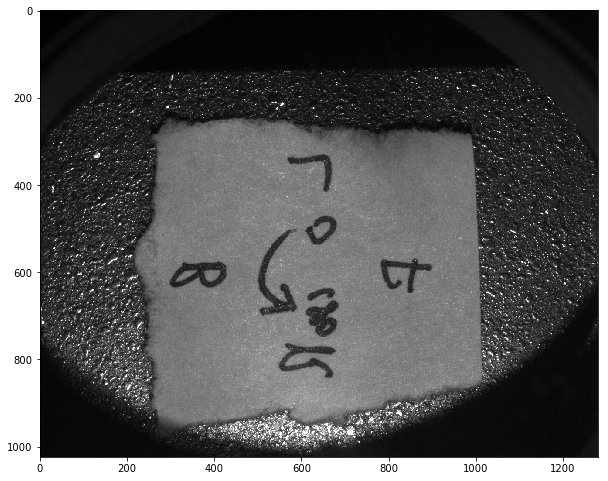

In [3]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(paper_pic, cmap='gray');

# ESS Validation Specimen

In [5]:
ess_raw_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.16.19\\2) pSFDI\\Sample\\Vertical\\Green'
ess_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.16.19\\2) pSFDI\\V_Green'

In [6]:
xrange, yrange = fileIO.read_psfdi_mask(ess_raw_path)
polar_res = 4
polar_max = 180
ess_planar = fileIO.read_no_sfx(ess_raw_path, xrange, yrange, polar_res, polar_max, 'planar')
ess_proc = fileIO.read_mat_file(os.path.join(ess_data_path, 'data_proc.mat'))
ess_phi = ess_proc['phi']

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
im0 = ax0.imshow(ess_planar[0, :, :], cmap='gray')

im1 = ax1.imshow(ess_phi, cmap='hsv');
divider = make_axes_locatable(ax1);
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax);

## Run through pSFDI loading process - Make this a little cleaner later

In [8]:
xrange, yrange = fileIO.read_psfdi_mask(ess_raw_path)

sfx_per = 36.9886
polar_res = 4
poloar_max = 180

sample_dark, sample_planar, sample_I0, sample_I120, sample_I240 = fileIO.read_raw_psfdi(ess_raw_path, xrange, yrange, sfx_per, polar_res, polar_max)

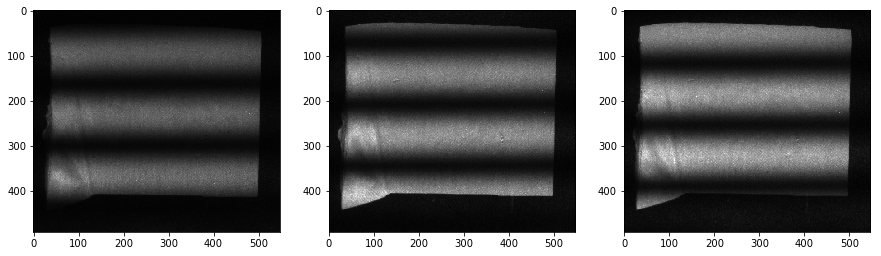

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 15))
ax0.imshow(sample_I0[0, :, :], cmap='gray');
ax1.imshow(sample_I120[0, :, :], cmap='gray');
ax2.imshow(sample_I240[0, :, :], cmap='gray');

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
ax0.imshow(sample_dark[0, :, :], cmap='gray')
ax1.imshow(sample_planar[0, :, :], cmap='gray');

In [10]:
sample_IDC, sample_IAC = imp.demodulate(sample_I0, sample_I120, sample_I240, polar_res, polar_max)

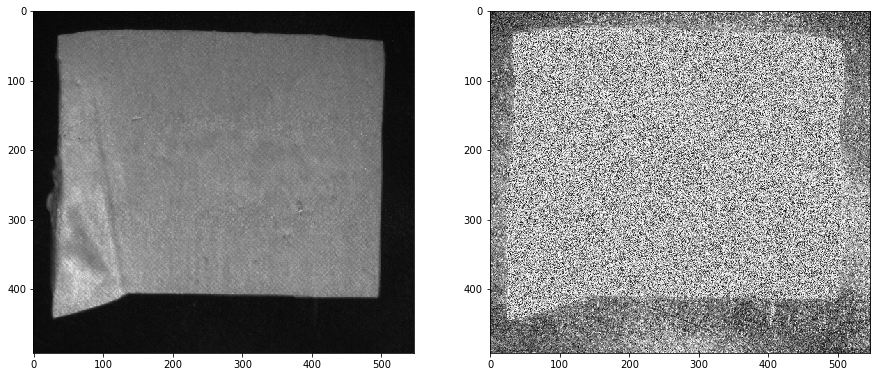

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
ax0.imshow(sample_IDC[0, :, :], cmap='gray')
ax1.imshow(sample_IAC[0, :, :], cmap='gray');

## SALS Data

In [12]:
ess_sals_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\ESS\\Results'

In [13]:
ess_sals_pd_im = cv2.imread(os.path.join(ess_sals_path, 'Images\ESS2_PrefD.png'), -1)
ess_sals_pd_im = cv2.cvtColor(ess_sals_pd_im, cv2.COLOR_BGR2RGB)

In [14]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(ess_sals_pd_im);

## Reading this data manually because there was some extra collected

In [15]:
# Initialize dictionary
SALS_dict = {}

with open(os.path.join(ess_sals_path, 'SALSA OUT TXT\\ESS2_SALSA.txt')) as f:
    SALS_data = [line.rstrip('\n') for line in f]

# Parse the header data
header_string = SALS_data[0]

# Split the data into individual parts
SALS_string_data = SALS_data[1:-1:6]
SALS_intensity_data = SALS_data[2:-1:6]
SALS_odd_data = SALS_data[3:-1:6]
SALS_odf_data = SALS_data[4:-1:6]
SALS_theta_data = SALS_data[5:-1:6]

# Split pixel level data
# split SALS data
SALS_string_list = [line.split('\t') for line in SALS_string_data]

# Get variables of interest
SALS_PD = [row[2] for row in SALS_string_list]
SALS_SD = [row[6] for row in SALS_string_list]
x = [row[0] for row in SALS_string_list]
y = [row[1] for row in SALS_string_list]

In [16]:
# Convert strings to floats
SALS_PD = list(map(float, SALS_PD[0:-13]))
SALS_SD = list(map(float, SALS_SD[0:-13]))
x = list(map(float, x[0:-13]))
y = list(map(float, y[0:-13]))

In [17]:
# Convert lists to numpy arrays
SALS_PD = np.array(SALS_PD)
SALS_SD = np.array(SALS_SD)
x = np.array(x)
y = np.array(y)

In [18]:
# Reshape the data
y_step = y[1] - y[0]
ydim = int(np.max(y) / y_step + 1)
xdim = int(len(y) / ydim)

In [19]:
x_2d = np.reshape(x, (xdim, ydim)).T
y_2d = np.reshape(y[::-1], (xdim, ydim)).T
PD_2d = np.reshape(SALS_PD, (xdim, ydim)).T
PD_2d = np.rad2deg(PD_2d)  # Convert radians to degrees
SD_2d = np.reshape(SALS_SD, (xdim, ydim)).T
SD_2d = np.rad2deg(SD_2d)  # Convert radians to degrees

# Add pixel data to dict
SALS_dict['x'] = x_2d
SALS_dict['y'] = y_2d
SALS_dict['PD'] = PD_2d
SALS_dict['SD'] = SD_2d

# Split pixel level data that also depends on theta
# Split strings
SALS_intensity_list = [line.split(';') for line in SALS_intensity_data]
SALS_odd_list = [line.split(';') for line in SALS_odd_data]
SALS_odf_list = [line.split(';') for line in SALS_odf_data]
SALS_theta_list = [line.split(';') for line in SALS_theta_data]

# Strings to floats
SALS_intensity = [list(map(float, row[:-1])) for row in SALS_intensity_list]
SALS_odd = [list(map(float, row[:-1])) for row in SALS_odd_list]
SALS_odf = [list(map(float, row[:-1])) for row in SALS_odf_list]
SALS_theta = [list(map(float, row[:-1])) for row in SALS_theta_list]

SALS_intensity = np.array(SALS_intensity)
SALS_odd = np.array(SALS_odd)
SALS_odf = np.array(SALS_odf)
SALS_theta = np.array(SALS_theta)

# Add pixel/theta data to dict
SALS_dict['intensity'] = SALS_intensity
SALS_dict['odd'] = SALS_odd
SALS_dict['odf'] = SALS_odf
SALS_dict['theta'] = SALS_theta

In [20]:
x = SALS_dict['x']
y = SALS_dict['y']

In [21]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax0.imshow(x)
ax0.set_title('X')
ax0.axis('equal')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im0, cax=cax);

im1 = ax1.imshow(y);
ax1.set_title('Y')
ax0.axis('equal')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax);

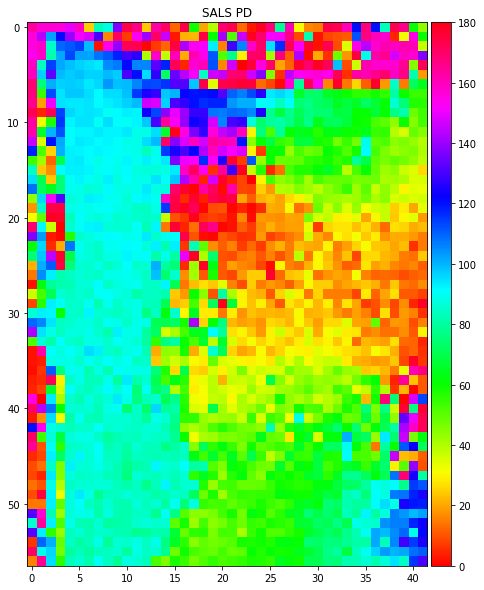

In [22]:
PD_2d = SALS_dict['PD']
# SALS PD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(PD_2d, cmap='hsv')
plt.title('SALS PD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 180);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

In [23]:
SD_2d = SALS_dict['SD']
# SALS SD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(SD_2d, cmap='jet')
plt.title('SALS SD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (45, 55);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

In [24]:
row = 15
col = 8
ydim = SALS_dict['PD'].shape[0]

row_step = int(sample_IDC.shape[1] / SALS_dict['PD'].shape[0])
col_step = int(sample_IDC.shape[2] / SALS_dict['PD'].shape[1])

psfdi_row = row * row_step
psfdi_col = col * col_step

index = col * ydim + (ydim - col)

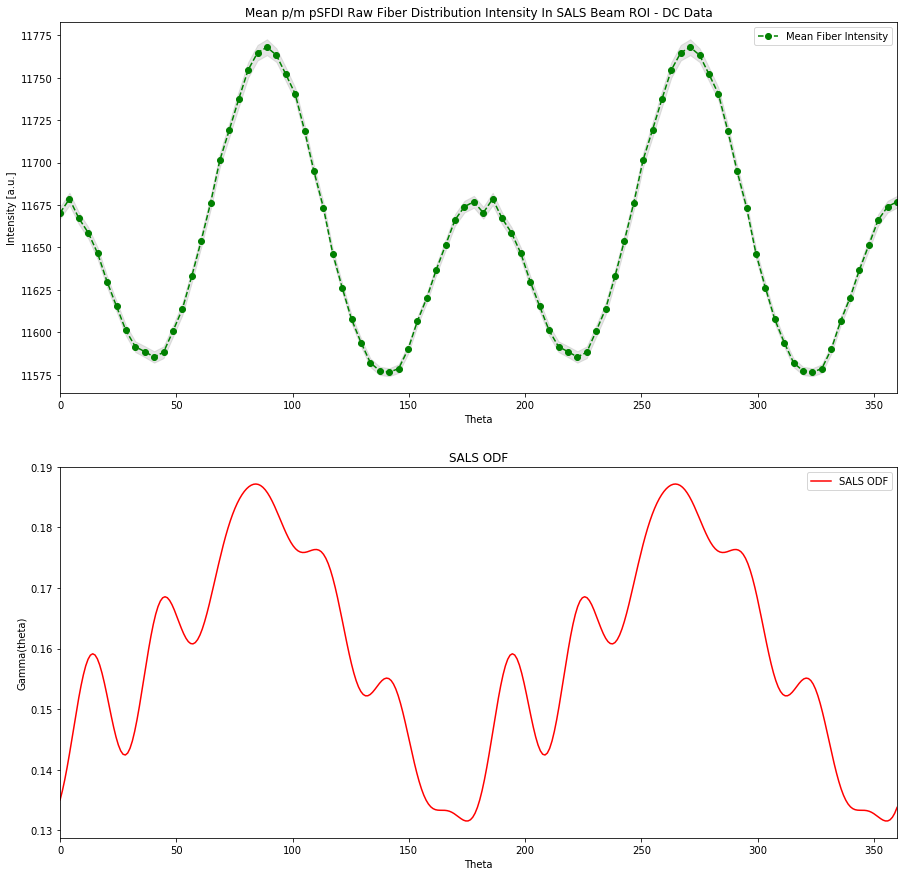

In [25]:
visualize.compare_raw_interactive(row, col, sample_IDC, 'DC', SALS_dict, roll=-22)

In [26]:
odf_theta = SALS_dict['theta'][index, :]
odf_gamma = SALS_dict['odf'][index, :]

In [27]:
an, bn, c = odf.fit_fourier(20, odf_gamma, odf_theta)
odf_fsfit = odf.compute_fourier(an, bn, c, odf_theta)

In [28]:
theta1, theta2 = odf.structural_eigenval_thetas(an[0], bn[0])

In [29]:
print('Theta I (deg): {}'.format(theta1))
print('Theta II (deg): {}'.format(theta2))

Theta I (deg): 175.19707369336913
Theta II (deg): -94.80292630663088


In [30]:
theta1_r = np.deg2rad(theta1)
theta2_r = np.deg2rad(theta2)
fig = plt.figure(figsize=(10, 10))
plt.polar(odf_theta, odf_fsfit, color='r', label='Fourier Series Fit');
plt.scatter(odf_theta, odf_gamma, s=10, label='SALS ODF Data');
plt.polar([theta1_r, theta1_r + np.pi], [0.20, 0.20], color='k', label='Theta I')
plt.polar([theta2_r, theta2_r + np.pi], [0.20, 0.20], color='g', label='Theta II')
plt.legend()
plt.title('SALS Data and Fourier Series Fit - Primary Directions on Polar Plot');

# Histology Sample

## Quick Look at the Processed Pref Direction Maps from SALS and pSFDI

In [31]:
hist_raw_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.18.19\\2) pSFDI\\Sample\\Vertical\\Green'
hist_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.18.19\\2) pSFDI\\V_Green'
hist_sals_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\Hist3\\Results'

In [32]:
# Load psfdi data and Matlab processed SALS data
hist_proc = fileIO.read_mat_file(os.path.join(hist_data_path, 'data_proc.mat'))
hist_phi = hist_proc['phi']
hist_a0 = hist_proc['a0']

hist_sals_PD_im = cv2.imread(os.path.join(hist_sals_path, 'Images\Hist3_PrefD.png'), -1)
hist_sals_PD_im = cv2.cvtColor(hist_sals_PD_im, cv2.COLOR_BGR2RGB)
hist_sals_maxint_im = cv2.imread(os.path.join(hist_sals_path, 'Images\Hist3_MaxIntensity.png'), -1)
hist_sals_maxint_im = cv2.cvtColor(hist_sals_maxint_im, cv2.COLOR_BGR2RGB)

In [33]:
# Visualize these results side by side
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
ax0.imshow(hist_sals_maxint_im);

im1 = ax1.imshow(hist_a0, cmap='gray');
divider = make_axes_locatable(ax1);
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax);

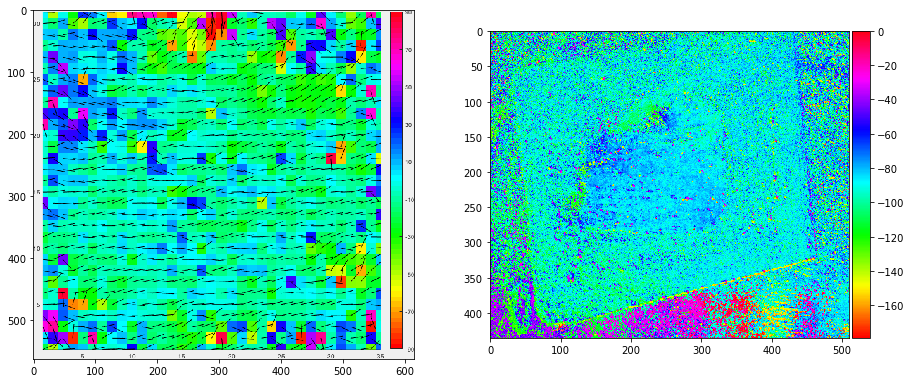

In [34]:
# Visualize these results side by side
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
ax0.imshow(hist_sals_PD_im);

im1 = ax1.imshow(hist_phi, cmap='hsv');
divider = make_axes_locatable(ax1);
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax);

## Load Raw intensity pSFDI Data

### Load mask

In [35]:
xrange, yrange = fileIO.read_psfdi_mask(hist_raw_path)

### Specify spatial frequency and polarizer resolution

In [36]:
sfx_per = 38.1503
polar_res = 4
poloar_max = 180

### Load and crop sample data

In [37]:
sample_dark, sample_planar, sample_I0, sample_I120, sample_I240 = fileIO.read_raw_psfdi(hist_raw_path, xrange, yrange, sfx_per, polar_res, polar_max)

### Visualize

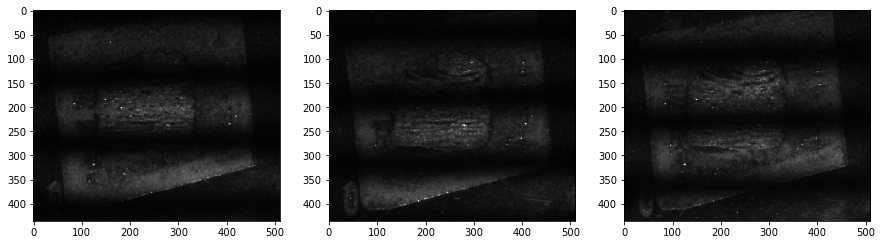

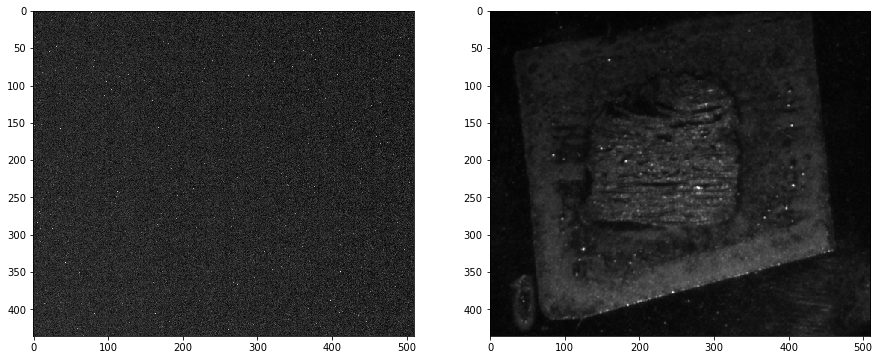

In [38]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 15))
ax0.imshow(sample_I0[0, :, :], cmap='gray');
ax1.imshow(sample_I120[0, :, :], cmap='gray');
ax2.imshow(sample_I240[0, :, :], cmap='gray');

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
ax0.imshow(sample_dark[0, :, :], cmap='gray')
ax1.imshow(sample_planar[0, :, :], cmap='gray');

### Load and crop standard images


### Median filter standard and dark images


### Demodulate images

In [39]:
sample_IDC, sample_IAC = imp.demodulate(sample_I0, sample_I120, sample_I240, polar_res, polar_max)

### Visualize

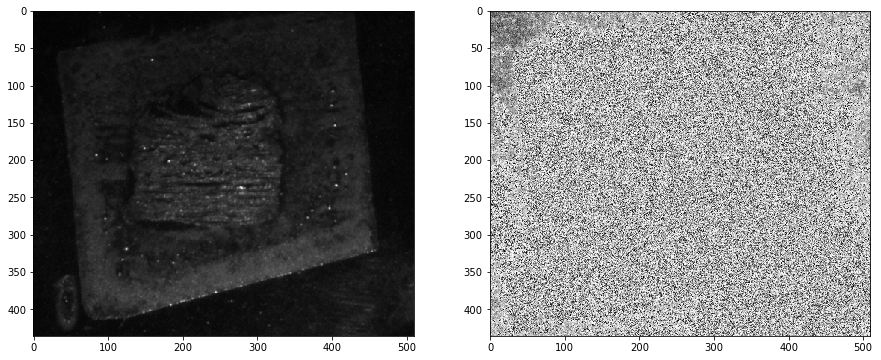

In [40]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
ax0.imshow(sample_IDC[0, :, :], cmap='gray')
ax1.imshow(sample_IAC[0, :, :], cmap='gray');

### Subtract out dark images

## Load SALS Data

In [41]:
SALS_data_dict = fileIO.read_SALS(os.path.join(hist_sals_path, 'SALSA OUT TXT\\Hist3_SALSA.txt'))

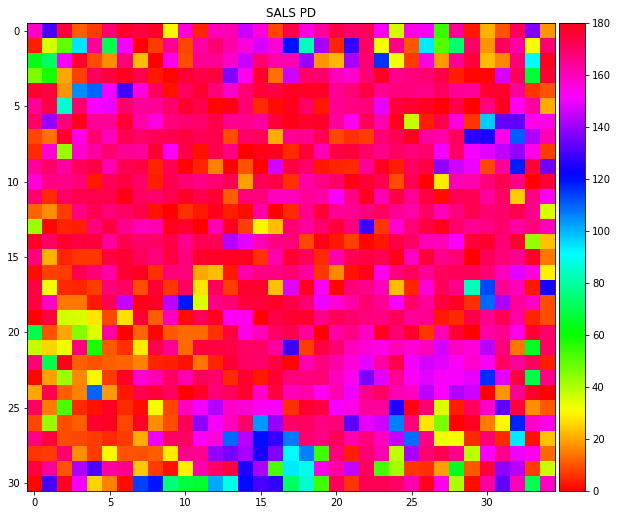

In [42]:
PD_2d = SALS_data_dict['PD']
# SALS PD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(PD_2d, cmap='hsv')
plt.title('SALS PD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 180);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

In [43]:
SD_2d = SALS_data_dict['SD']
# SALS SD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(SD_2d, cmap='jet')
plt.title('SALS SD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (45, 55);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

# BP Data

## Load Raw Intensity pSFDI Data

### Specify file paths

In [44]:
sample_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.15.19b\\2) pSFDI\\Sample\\Vertical\\Green'
standard_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.15.19b\\1) Standard\\Standard\\Vertical\\Green'

### Load mask

In [45]:
xrange, yrange = fileIO.read_psfdi_mask(sample_data_path)

### Specify spatial frequency and polarizer resolution

In [46]:
sfx_per = 37.1622
polar_res = 4
polar_max = 180

### Load and crop sample data

In [47]:
sample_dark, sample_planar, sample_I0, sample_I120, sample_I240 = fileIO.read_raw_psfdi(sample_data_path, xrange, yrange, sfx_per, polar_res, polar_max)

### Visualize

In [48]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 15))
ax0.imshow(sample_I0[0, :, :], cmap='gray');
ax1.imshow(sample_I120[0, :, :], cmap='gray');
ax2.imshow(sample_I240[0, :, :], cmap='gray');

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
ax0.imshow(sample_dark[0, :, :], cmap='gray')
ax1.imshow(sample_planar[0, :, :], cmap='gray');

### Load and crop standard images

### Median filter standard and dark images

### Demodulate Images

In [49]:
sample_IDC, sample_IAC = imp.demodulate(sample_I0, sample_I120, sample_I240, polar_res, polar_max)

### Visualize

In [50]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
ax0.imshow(sample_IDC[0, :, :], cmap='gray')
ax1.imshow(sample_IAC[0, :, :], cmap='gray');

### Subtract out dark images

## Load in SALS data

In [51]:
SALS_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\BP\\Results\\BP ODF 032919'

SALS_data_dict = fileIO.read_SALS(os.path.join(SALS_data_path, 'SALSA OUT TXT\\BP_ODF_Extraction_032919_SALSA.txt'))

In [52]:
sals_pd_im = cv2.imread(os.path.join(SALS_data_path, 'Images\\BP_ODF_Extraction_032919_PrefD.png'), -1)
sals_pd_im = cv2.cvtColor(sals_pd_im, cv2.COLOR_BGR2RGB)

In [53]:
fig = plt.figure(figsize=(15, 15))
plt.title('SALSA Processed PD')
plt.imshow(sals_pd_im);

In [54]:
x = SALS_data_dict['x']
y = SALS_data_dict['y']

In [55]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax0.imshow(x)
ax0.set_title('X')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im0, cax=cax);

im1 = ax1.imshow(y);
ax1.set_title('Y')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax);

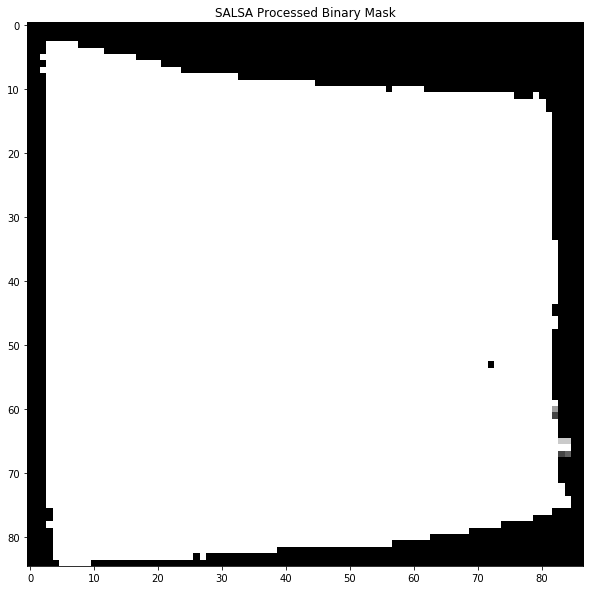

In [56]:
PD_2d = SALS_data_dict['PD']
SD_2d = SALS_data_dict['SD']

sals_mask = cv2.imread(os.path.join(SALS_data_path, 'BW_Images\\BP_ODF_Extraction_032919.tif'), -1)
sals_mask = cv2.resize(sals_mask, PD_2d.shape[::-1])

# SALS Mask
fig = plt.figure(figsize=(10, 10))
plt.imshow(sals_mask)
plt.title('SALSA Processed Binary Mask');

In [57]:
sals_mask[:, :, 0].shape

(85, 87)

In [58]:
PD_2d.shape

(85, 87)

In [59]:
SALS_data_dict['x'].shape

(85, 87)

In [60]:
# SALS PD
masked_PD = np.zeros(PD_2d.shape) * np.nan
index_bool = sals_mask[:, :, 0].astype(bool)
masked_PD[index_bool] = PD_2d[index_bool]


fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(masked_PD, cmap='hsv')
plt.title('SALS PD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 180);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

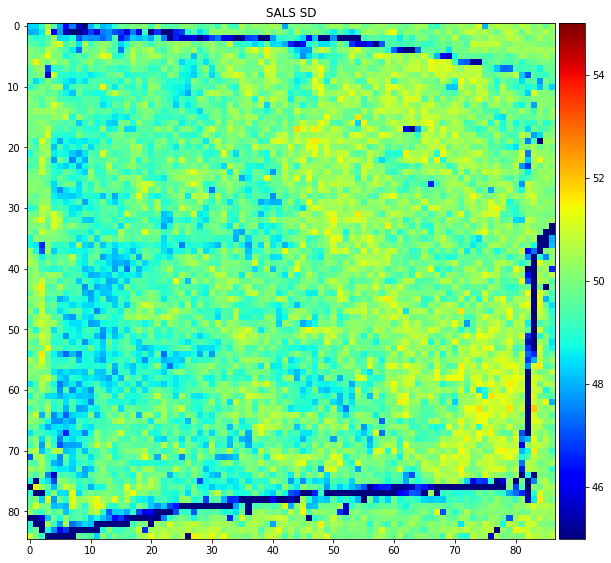

In [61]:
# SALS SD
masked_SD = np.zeros(SD_2d.shape) * np.nan
index_bool = sals_mask[:, :, 0].astype(bool)
masked_SD[index_bool] = SD_2d[index_bool]

fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(SD_2d, cmap='jet')
plt.title('SALS SD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (45, 55);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

In [62]:
# Save a file for masking a mask
name = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\Results\\BP ODF 032919\\BW_Images\\color_premask.png'
plt.imsave(name, SD_2d, format='png', cmap='jet', vmin=45, vmax=55)

## Feasibility Study - Raw Data

### No extra registration. This isn't completely correct, but okay for now. Can improve by multiplying warp matrix translation by numer of psfdi pixels in SALS pixel as a start.

## Set the row and column data from visualization etc

In [98]:
row = 60
col = 20
ydim = SALS_data_dict['PD'].shape[0]

row_step = int(sample_IDC.shape[1] / SALS_data_dict['PD'].shape[0])
col_step = int(sample_IDC.shape[2] / SALS_data_dict['PD'].shape[1])

psfdi_row = row * row_step
psfdi_col = col * col_step

index = col * ydim + (ydim - col)

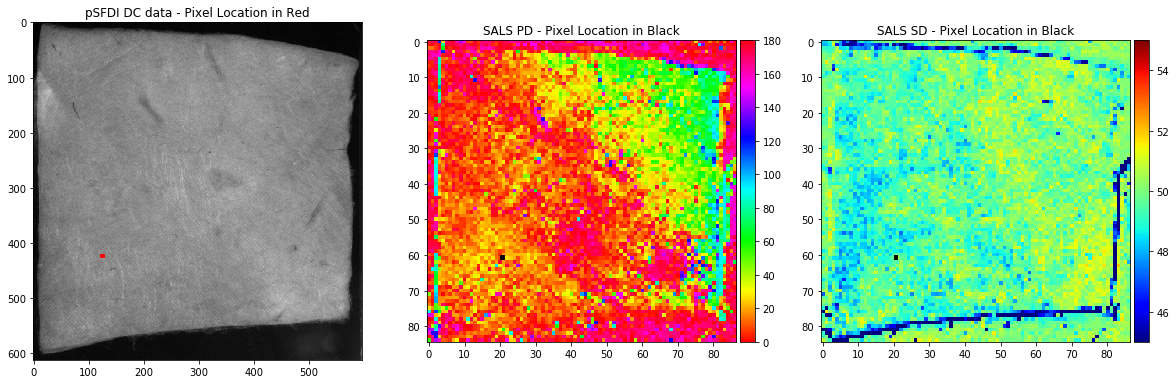

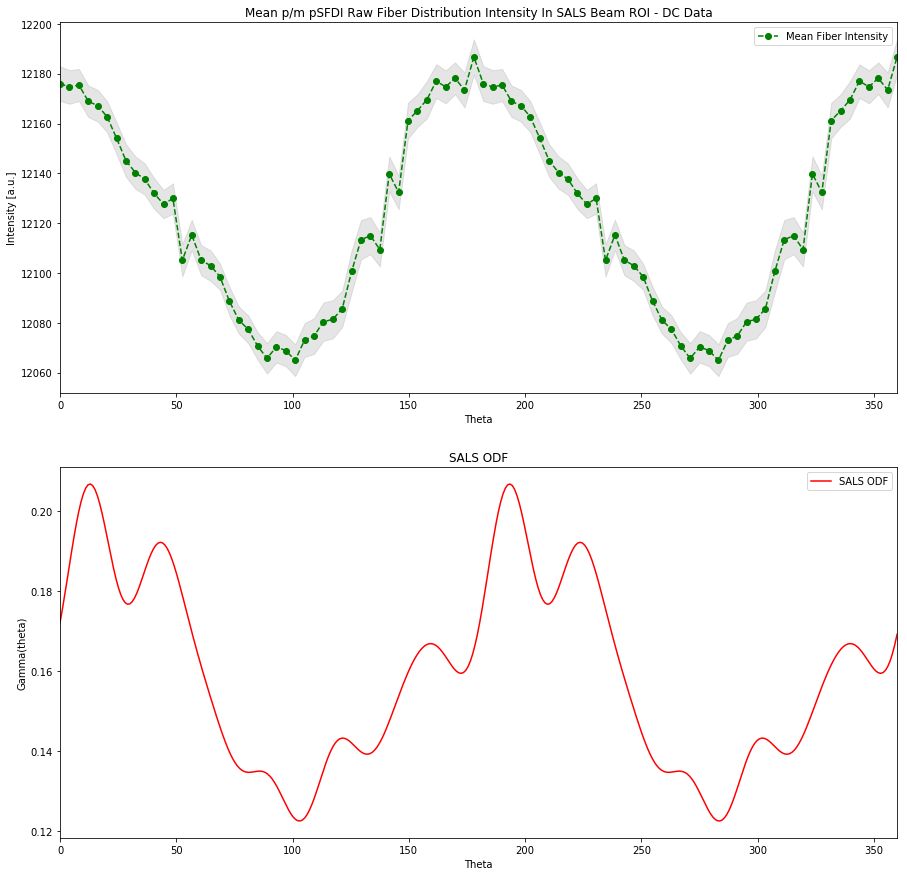

In [99]:
visualize.compare_raw_interactive(row, col, sample_IDC, 'DC', SALS_data_dict, roll=-22)

## Fourier Series Fit

### SALS Data

In [100]:
odf_theta = SALS_data_dict['theta'][index, :]
odf_gamma = SALS_data_dict['odf'][index, :]

In [101]:
an, bn, c = odf.fit_fourier(20, odf_gamma, odf_theta)
odf_fsfit = odf.compute_fourier(an, bn, c, odf_theta)

In [102]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(np.rad2deg(odf_theta), odf_gamma, marker='o', s=10, label='SALS ODF Data')
plt.plot(np.rad2deg(odf_theta), odf_fsfit, color='r', label='Fourier Series Fit');
plt.ylabel('Gamma');
plt.xlabel('Theta');
plt.legend()
plt.title('SALS ODF Data and Associated Fourer Series Fit');

In [103]:
fig = plt.figure(figsize=(10, 10))
plt.polar(odf_theta, odf_fsfit, color='r', label='Fourier Series Fit');
plt.scatter(odf_theta, odf_gamma, s=10, label='SALS ODF Data');
plt.legend()
plt.title('SALS ODF Data and Associated Fourier Series Fit - Polar Plot');

## Compute the Primary and Secondary Directions

In [104]:
theta1, theta2 = odf.structural_eigenval_thetas(an[0], bn[0])

In [105]:
print('Theta I (deg): {}'.format(theta1))
print('Theta II (deg): {}'.format(theta2))

Theta I (deg): 19.726877045967672
Theta II (deg): 109.72687704596768


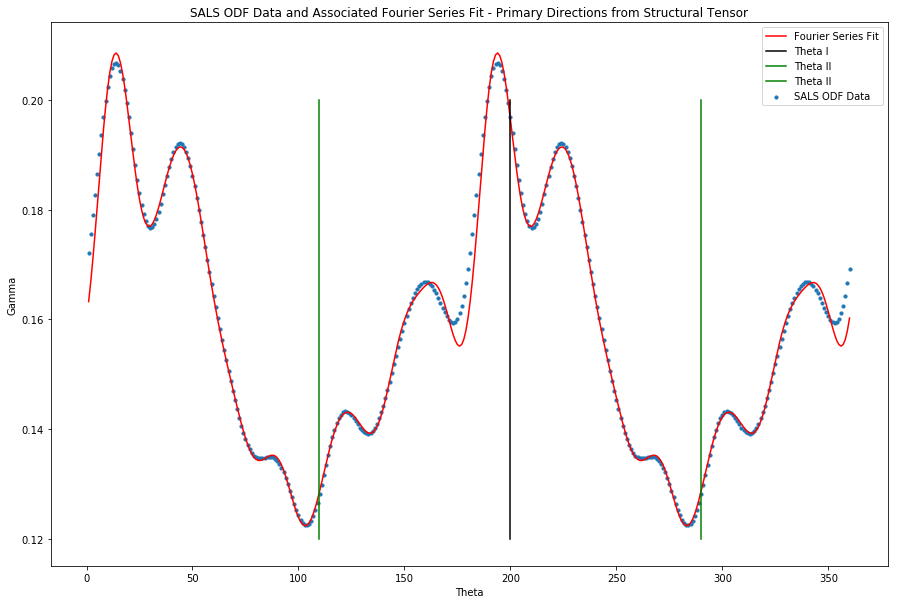

In [106]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(np.rad2deg(odf_theta), odf_gamma, s=10, label='SALS ODF Data');
plt.plot(np.rad2deg(odf_theta), odf_fsfit, color='r', label='Fourier Series Fit')
plt.plot((theta1 + 180) * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='k', label='Theta I')
plt.plot(theta2 * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='g', label='Theta II')
plt.plot((theta2 + 180) * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='g', label='Theta II')
plt.xlabel('Theta')
plt.ylabel('Gamma')
plt.legend();
plt.title('SALS ODF Data and Associated Fourier Series Fit - Primary Directions from Structural Tensor');

In [107]:
theta1_r = np.deg2rad(theta1)
theta2_r = np.deg2rad(theta2)
fig = plt.figure(figsize=(10, 10))
plt.polar(odf_theta, odf_fsfit, color='r', label='Fourier Series Fit');
plt.scatter(odf_theta, odf_gamma, s=10, label='SALS ODF Data');
plt.polar([theta1_r, theta1_r + np.pi], [0.20, 0.20], color='k', label='Theta I')
plt.polar([theta2_r, theta2_r + np.pi], [0.20, 0.20], color='g', label='Theta II')
plt.legend()
plt.title('SALS Data and Fourier Series Fit - Primary Directions on Polar Plot');